# Clustering

The vast majority of the available data today is unlabeled: we have the input features $X$, but we do not have the labels $y$. We can fairly easily create systems to build large datasets, but we need also labels. If we want to train a regular binary classifier, we will need to label every single items. This will generally require human experts to sit down and manually go through all the items. This is a long, costly, and tedious task, so it will usually only be done on a small subset of the available items. As a result, the labeled datasets will be quite small, and the classifier’s performance will be disappointing. Wouldn’t it be great if the algorithm could just exploit the unlabeled data without needing humans to label every item? Enter unsupervised learning.

In [1]:
import numpy as np

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

np.random.seed(42)

import warnings
warnings.filterwarnings('ignore')

The most important task of unsupervised learning is **clustering**. The goal is to identify similar instances and assigning them to clusters, or groups of similar instances.  

Consider the iris dataset, where each instance’s species is represented with a different marker. It is a labeled dataset, for which classification algorithms are well suited. If we consider the same dataset, but without the labels, we cannot use a classification algorithm anymore. This is where clustering algorithms step in: many of them can easily detect the lower-left cluster. It is also quite easy to see with our own eyes, but it is not so obvious that the upper-right cluster is composed of two distinct sub-clusters.

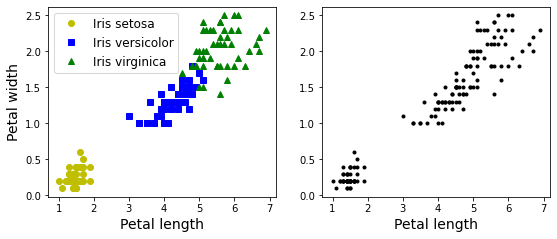

In [2]:
from sklearn.datasets import load_iris

data = load_iris()
X = data.data
y = data.target
data.target_names

plt.figure(figsize=(9, 3.5))
plt.subplot(121)

plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris virginica")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(fontsize=12)

plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("Petal length", fontsize=14)

plt.show()

Clustering is used in a wide variety of applications, including: customer segmentation (useful in recommender systems), data analysis, anomaly detection, semi-supervised learning, search engines, image segmentation, etc.

## K-Means

Consider the following unlabeled dataset, we can clearly see five blobs of  instances. The K-Means algorithm ([Stuart P. Lloyd **Least Squares Quantization in PCM** IEEE Transactions on Information Theory 28, no. 2 (1982)](https://ieeexplore.ieee.org/abstract/document/1056489/similar#similar)) is a simple algorithm capable of clustering this kind of dataset very quickly and efficiently, often in just a few iterations.

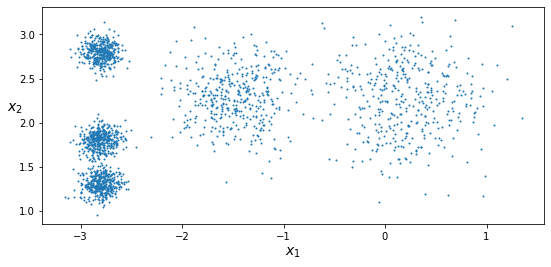

In [3]:
from sklearn.datasets import make_blobs

blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

X, y = make_blobs(n_samples=2000, centers=blob_centers, cluster_std=blob_std, random_state=7)

def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)
    
plt.figure(figsize=(9, 4))
plot_clusters(X)
plt.show()

The **K-Means algorithm** is one of the fastest clustering algorithms, but also one of the simplest. Suppose we were given the centroids. We could easily label all the instances in the dataset by assigning each of them to the cluster whose centroid is closest. Conversely, if we were given all the instance labels, we could easily locate all the centroids by computing the mean of the instances for each cluster. But we are given neither the labels nor the centroids, so how can you proceed? Well, just start by placing the centroids randomly (e.g., by picking k instances at random and using their locations as centroids). Then label the instances, update the centroids, label the instances, update the centroids, and so on until the centroids stop moving. The algorithm is guaranteed to converge in a finite number of steps (usually quite small).

Each input is a vector in d-dimensional space and we will represent it as a list of numbers. Our goal will be to identify clusters of similar inputs and to find a representative value for each cluster. We’ll settle for an iterative algorithm that usually finds a good clustering:
1. start with a set of k-means, which are points in d-dimensional space.
2. assign each point to the mean to which it is closest.
3. if no point’s assignment has changed, stop and keep the clusters.
4. if some point’s assignment has changed, recompute the means and return to step 2.

To start with, we create some helper function for managing vectors:

In [16]:
def scalar_multiply(c, v):
    """Multiplies every element by c"""
    return [c * v_i for v_i in v]

def dot(v, w):
    """Computes v_1 * w_1 + ... + v_n * w_n"""
    assert len(v) == len(w), "vectors must be same length"
    return sum(v_i * w_i for v_i, w_i in zip(v, w))

def sum_of_squares(v):
    """Returns v_1 * v_1 + ... + v_n * v_n"""
    return dot(v, v)

def subtract(v, w):
    """Subtracts corresponding elements"""
    assert len(v) == len(w), "vectors must be the same length"
    return [v_i - w_i for v_i, w_i in zip(v, w)]

def squared_distance(v, w):
    """Computes (v_1 - w_1) ** 2 + ... + (v_n - w_n) ** 2"""
    return sum_of_squares(subtract(v, w))

def vector_sum(vectors):
    """Sums all corresponding elements"""
    num_elements = len(vectors[0])
    assert all(len(v) == num_elements for v in vectors), "different sizes!"
    # the i-th element of the result is the sum of every vector[i]
    return [sum(vector[i] for vector in vectors)
            for i in range(num_elements)]

def vector_mean(vectors):
    """Computes the element-wise average"""
    n = len(vectors)
    return scalar_multiply(1/n, vector_sum(vectors))

def cluster_means(k, inputs, assignments):
    clusters = [[] for i in range(k)]
    for input, assignment in zip(inputs, assignments):
        clusters[assignment].append(input)
    return [vector_mean(cluster) if cluster else random.choice(inputs)
            for cluster in clusters]

def num_differences(v1, v2):
    assert len(v1) == len(v2)
    return len([x1 for x1, x2 in zip(v1, v2) if x1 != x2])

In [17]:
import itertools
import random
import tqdm

class MyKMeans:
    def __init__(self, k):
        self.k = k                      # number of clusters
        self.means = None

    def classify(self, input):
        """return the index of the cluster closest to the input"""
        return min(range(self.k),
                   key=lambda i: squared_distance(input, self.means[i]))

    def train(self, inputs):
        # Start with random assignments
        assignments = [random.randrange(self.k) for _ in inputs]

        with tqdm.tqdm(itertools.count()) as t:
            for _ in t:
                # Compute means and find new assignments
                self.means = cluster_means(self.k, inputs, assignments)
                new_assignments = [self.classify(input) for input in inputs]

                # Check how many assignments changed and if we're done
                num_changed = num_differences(assignments, new_assignments)
                if num_changed == 0:
                    return

                # Otherwise keep the new assignments, and compute new means
                assignments = new_assignments
                self.means = cluster_means(self.k, inputs, assignments)
                t.set_description(f"changed: {num_changed} / {len(inputs)}")

Let's try on the previous example:

In [18]:
import random
random.seed(0) 

clusterer = MyKMeans(k=5)
clusterer.train(X)

changed: 1 / 2000: : 5it [00:00, 19.61it/s]  


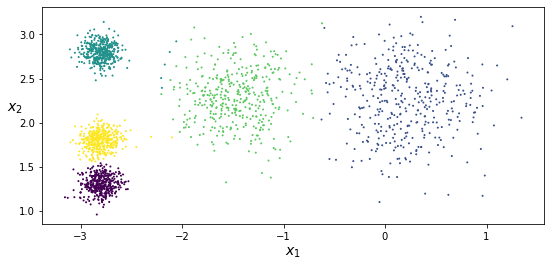

In [19]:
y_pred_scratch = [clusterer.classify(element) for element in X]

plt.figure(figsize=(9, 4))
plot_clusters(X, y_pred_scratch)
plt.show()

Let’s train a K-Means clusterer on this dataset using the SciKitLearn **KMeans class**. It will try to find each blob’s center and assign each instance to the closest blob. Note that we have to specify the number of clusters k that the algorithm must find. In this example, it is pretty obvious from looking at the data that k should be set to 5, but in general it is not that easy.

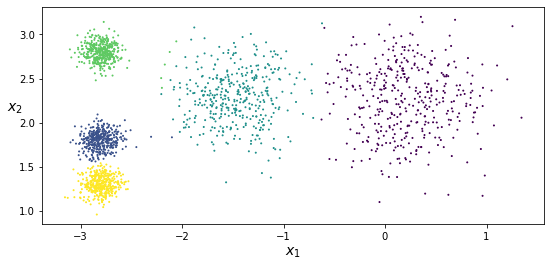

In [20]:
from sklearn.cluster import KMeans
k = 5
kmeans = KMeans(n_clusters=k)
y_pred = kmeans.fit_predict(X)

plt.figure(figsize=(9, 4))
plot_clusters(X, y_pred)
plt.show()

Each instance was assigned to one of the five clusters. The **label** of an instance in this context is the index of the cluster that instance gets assigned to.

In [21]:
print(y_pred)

[4 1 0 ... 3 0 1]


We can also take a look at the five **centroids** that the algorithm found.

In [22]:
kmeans.cluster_centers_

array([[ 0.20876306,  2.25551336],
       [-2.80389616,  1.80117999],
       [-1.46679593,  2.28585348],
       [-2.79290307,  2.79641063],
       [-2.80037642,  1.30082566]])

Of course, we can predict the labels of new instances:

In [23]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([0, 0, 3, 3], dtype=int32)

### Decision boundaries

We can plot the **decision boundaries** 

In [24]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, show_centroids=True):
    resolution=1000
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), linewidths=1, colors='k')
    plot_data(X)
    if show_centroids: plot_centroids(clusterer.cluster_centers_)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

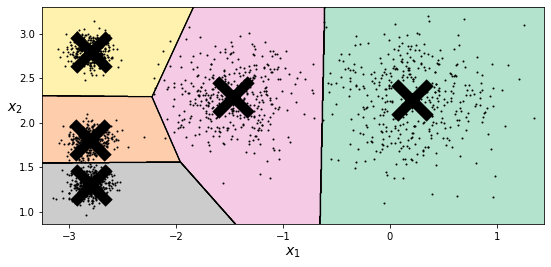

In [25]:
plt.figure(figsize=(9, 4))
plot_decision_boundaries(kmeans, X)
plt.show()

The vast majority of the instances were clearly assigned to the appropriate cluster, but a few instances were probably mislabeled (especially near the boundary between the top-left cluster and the central cluster). Indeed, the K-Means algorithm does not behave very well when the blobs have very different diameters because all it cares about when assigning an instance to a cluster is the distance to the centroid.

Instead of assigning each instance to a single cluster (**hard clustering**), it can be useful to give each instance a score per cluster (**soft clustering**). The score can be the distance between the instance and the centroid; conversely, it can be a similarity score (or affinity). In the KMeans class, the transform() method measures the distance from each instance to every centroid:

In [26]:
kmeans.transform(X_new)

array([[0.32995317, 2.81093633, 1.49439034, 2.9042344 , 2.88633901],
       [2.80290755, 5.80730058, 4.4759332 , 5.84739223, 5.84236351],
       [3.29399768, 1.21475352, 1.69136631, 0.29040966, 1.71086031],
       [3.21806371, 0.72581411, 1.54808703, 0.36159148, 1.21567622]])

We can verify that this is the Euclidian distance between each instance and each centroid:

In [27]:
np.linalg.norm(np.tile(X_new, (1, k)).reshape(-1, k, 2) - kmeans.cluster_centers_, axis=2)

array([[0.32995317, 2.81093633, 1.49439034, 2.9042344 , 2.88633901],
       [2.80290755, 5.80730058, 4.4759332 , 5.84739223, 5.84236351],
       [3.29399768, 1.21475352, 1.69136631, 0.29040966, 1.71086031],
       [3.21806371, 0.72581411, 1.54808703, 0.36159148, 1.21567622]])

We can try to see the algorithm in action. The KMeans class applies an optimized algorithm by default. To get the original algorithm (for educational purposes only), we have to set **init="random"**, **n_init=1** and **algorithm="full"**. Let's run the K-Means algorithm for some iterations, to see how the centroids move around:

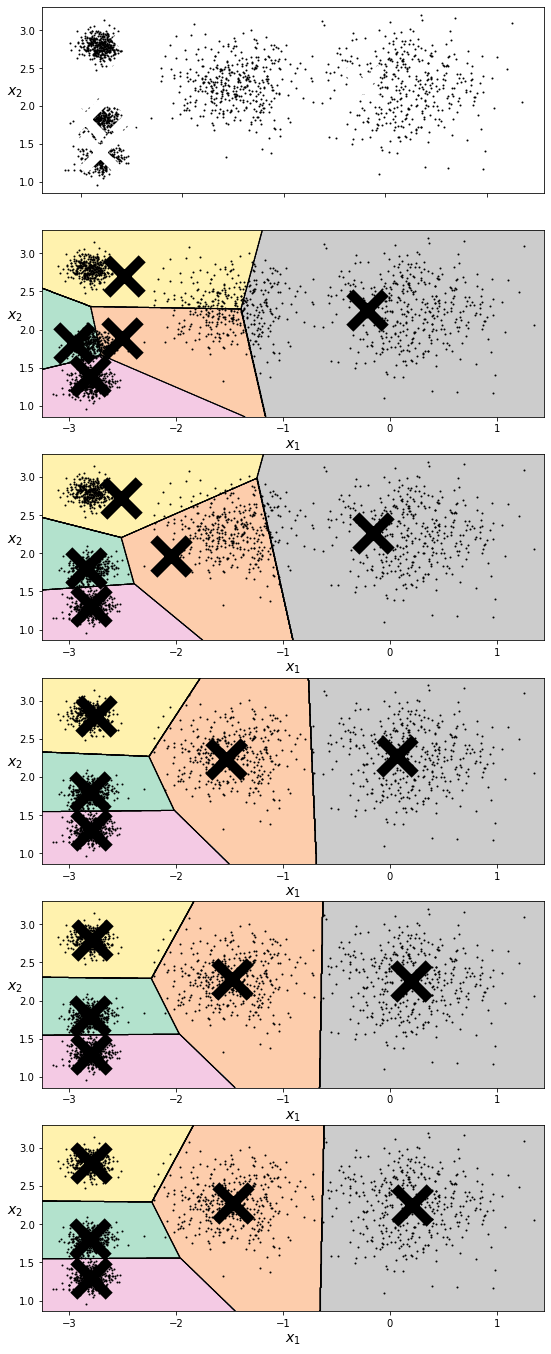

In [28]:
kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1, algorithm="full", max_iter=1, random_state=1)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1, algorithm="full", max_iter=2, random_state=1)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1, algorithm="full", max_iter=3, random_state=1)
kmeans_iter4 = KMeans(n_clusters=5, init="random", n_init=1, algorithm="full", max_iter=4, random_state=1)
kmeans_iter5 = KMeans(n_clusters=5, init="random", n_init=1, algorithm="full", max_iter=5, random_state=1)
kmeans_iter6 = KMeans(n_clusters=5, init="random", n_init=1, algorithm="full", max_iter=6, random_state=1)

kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)
kmeans_iter4.fit(X)
kmeans_iter5.fit(X)
kmeans_iter6.fit(X)

plt.figure(figsize=(9, 24))

plt.subplot(611)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)

plt.subplot(612)
plot_decision_boundaries(kmeans_iter1, X)

plt.subplot(613)
plot_decision_boundaries(kmeans_iter2, X)

plt.subplot(614)
plot_decision_boundaries(kmeans_iter3, X)

plt.subplot(615)
plot_decision_boundaries(kmeans_iter4, X)

plt.subplot(616)
plot_decision_boundaries(kmeans_iter5, X)

plt.show()

The centroids are initialized randomly (first figure), then the centroids are updated and so on. As you can see, in just five iterations, the algorithm has reached a clustering that seems close to optimal.

Although the algorithm is guaranteed to converge, it may not converge to the right solution (i.e., it may converge to a local optimum): whether it does or not depends on the centroid initialization. In the next figure we try a completelly different ransom seed.

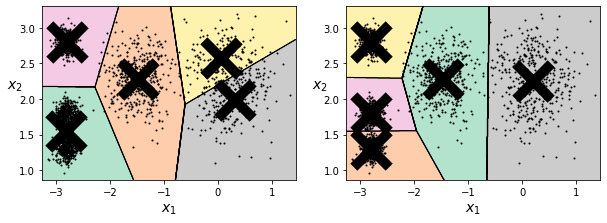

In [37]:
kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1, algorithm="full", random_state=2)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1, algorithm="full", random_state=5)

kmeans_rnd_init1.fit(X)
kmeans_rnd_init2.fit(X)

plt.figure(figsize=(10, 3.2))
plt.subplot(121)
plot_decision_boundaries(kmeans_rnd_init1, X)
plt.subplot(122)
plot_decision_boundaries(kmeans_rnd_init2, X)

plt.show()

If we know approximately where the centroids should be, then we can set the init
hyperparameter to a NumPy array containing the list of centroids, and set n_init to 1

In [38]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1)
kmeans.fit(X)

KMeans(init=array([[-3,  3],
       [-3,  2],
       [-3,  1],
       [-1,  2],
       [ 0,  2]]),
       n_clusters=5, n_init=1)

### Inertia

A solution to the dependance to centroid initialization is to run the algorithm multiple times with different random initializations and keep the best solution. The number of random initializations is controlled by the n_init hyperparameter (default 10). But how exactly does it know which solution is the best? We can use a performance metric called **inertia**, which is the mean squared distance between each instance and its closest centroid.
A model’s inertia is accessible via the **inertia_ variable**:

In [40]:
print(kmeans_rnd_init1.inertia_)
print(kmeans_rnd_init2.inertia_)

219.43539442771402
211.5985372581684


We can verify that inertia is the sum of the squared distances between each training instance and its closest centroid:

In [41]:
X_dist = kmeans.transform(X)
np.sum(X_dist[np.arange(len(X_dist)), kmeans.labels_]**2)

211.5985372581689

The KMeans class runs the algorithm n_init times and keeps the model with the lowest inertia.

### K-Means++

An important improvement, called **K-Means++** ([D. Arthur et al. **k-Means++: The Advantages of Careful Seeding**. Proceedings of the 18th Annual ACM-SIAM Symposium on Discrete Algorithms (2007)](https://dl.acm.org/doi/10.5555/1283383.1283494)) introduces a smarter initialization step that tends to select centroids that are distant from one another. This additional computation step is well worth it because it makes it possible to drastically reduce the number of times the algorithm needs to be run to find the optimal solution.

* take one centroid $c_1$, chosen uniformly at random from the dataset;
* take a new center $c_i$, choosing an instance $\mathbf{x}_i$ with probability: $D(\mathbf{x}_i)^2$ / $\sum\limits_{j=1}^{m}{D(\mathbf{x}_j)}^2$ where $D(\mathbf{x}_i)$ is the distance between the instance $\mathbf{x}_i$ and the closest centroid that was already chosen. This probability distribution ensures that instances that are further away from already chosen centroids are much more likely be selected as centroids.
* repeat the previous step until all $k$ centroids have been chosen.

The rest of the K-Means++ algorithm is just regular K-Means. With this initialization, the K-Means algorithm is much less likely to converge to a suboptimal solution, so it is possible to reduce n_init considerably. 

To set the initialization to K-Means++, simply set **init="k-means++"** (this is actually the default)

### Accelerated K-Means

The K-Means algorithm can be significantly accelerated by avoiding many unnecessary distance calculations: this is achieved by exploiting the triangle inequality (given three points $A$, $B$ and $C$, the distance $AC$ is always such that $AC \leq AB + BC$) and by keeping track of lower and upper bounds for distances between instances and centroids ([C. Elkan, **Using the Triangle Inequality to Accelerate k-Means**, Proceedings of the 20th International Conference on Machine Learning (2003)](https://dl.acm.org/doi/10.5555/3041838.3041857)).

To use this variant, just set **algorithm="elkan"**. 

In [42]:
%timeit -n 50 KMeans(algorithm="elkan").fit(X)

160 ms ± 25.1 ms per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [43]:
%timeit -n 50 KMeans(algorithm="full").fit(X)

221 ms ± 13.9 ms per loop (mean ± std. dev. of 7 runs, 50 loops each)


Another important variant: instead of using the full dataset at each iteration, the algorithm is capable of using mini-batches, moving the centroids just slightly at each iteration. This speeds up the algorithm typically by a factor of three or four and makes it possible to cluster huge datasets that do not fit in memory ([D. Sculley **Web-Scale K-Means Clustering** Proceedings of the 19th International
Conference on World Wide Web (2010)](https://dl.acm.org/doi/10.1145/1772690.1772862)).

Scikit-Learn implements this algorithm in the **MiniBatchKMeans class**.

In [45]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)
minibatch_kmeans.fit(X)

minibatch_kmeans.inertia_

211.65239850433204

If the dataset does not fit in memory, we can train the model by feeding it one batch at a time using the **partial_fit()** method.

In [46]:
def load_next_batch(batch_size):
    return X[np.random.choice(len(X), batch_size, replace=False)]

k = 5
n_init = 10
n_iterations = 100
batch_size = 100
init_size = 500  # more data for K-Means++ initialization
evaluate_on_last_n_iters = 10

best_kmeans = None

for init in range(n_init):
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, init_size=init_size)
    X_init = load_next_batch(init_size)
    minibatch_kmeans.partial_fit(X_init)

    minibatch_kmeans.sum_inertia_ = 0
    for iteration in range(n_iterations):
        X_batch = load_next_batch(batch_size)
        minibatch_kmeans.partial_fit(X_batch)
        if iteration >= n_iterations - evaluate_on_last_n_iters:
            minibatch_kmeans.sum_inertia_ += minibatch_kmeans.inertia_

    if (best_kmeans is None or
        minibatch_kmeans.sum_inertia_ < best_kmeans.sum_inertia_):
        best_kmeans = minibatch_kmeans

In [47]:
best_kmeans.score(X)

-211.7136228578621

Mini-batch K-Means is much faster than regular K-Means:

In [48]:
%timeit KMeans(n_clusters=5).fit(X)

85 ms ± 4.72 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [49]:
%timeit MiniBatchKMeans(n_clusters=5).fit(X)

60.4 ms ± 3.39 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


However, its performance is often lower (higher inertia), and it keeps degrading as $k$ increases. Let's plot the inertia ratio and the training time ratio between Mini-batch K-Means and regular K-Means.

100/100

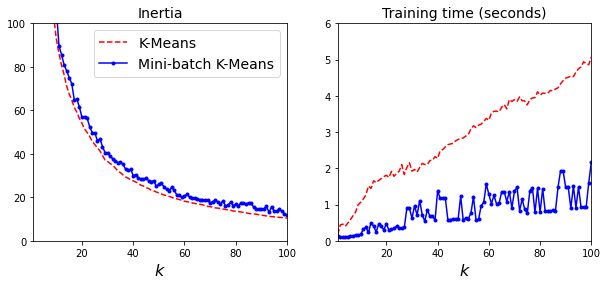

In [72]:
from timeit import timeit

times = np.empty((100, 2))
inertias = np.empty((100, 2))

for k in range(1, 101):
    kmeans_ = KMeans(n_clusters=k, random_state=42)
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
    print("\r{}/{}".format(k, 100), end="")
    times[k-1, 0] = timeit("kmeans_.fit(X)", number=10, globals=globals())
    times[k-1, 1]  = timeit("minibatch_kmeans.fit(X)", number=10, globals=globals())
    inertias[k-1, 0] = kmeans_.inertia_
    inertias[k-1, 1] = minibatch_kmeans.inertia_
    
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(range(1, 101), inertias[:, 0], "r--", label="K-Means")
plt.plot(range(1, 101), inertias[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Inertia", fontsize=14)
plt.legend(fontsize=14)
plt.axis([1, 100, 0, 100])

plt.subplot(122)
plt.plot(range(1, 101), times[:, 0], "r--", label="K-Means")
plt.plot(range(1, 101), times[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Training time (seconds)", fontsize=14)
plt.axis([1, 100, 0, 6])

plt.show()

### Finding the optimal number of clusters

In general, it will not be easy to know how to set $k$, and the result might be
quite bad if we set it to the wrong value. As you can see in the following figures,
setting $k$ to 3 or 8 results in fairly bad models.

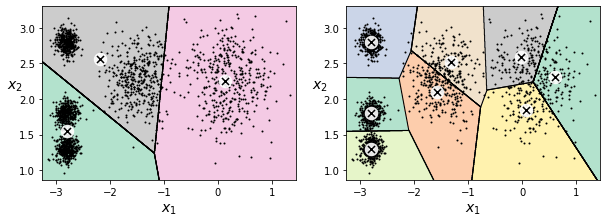

In [73]:
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, random_state=42)

kmeans_k3.fit(X)
kmeans_k8.fit(X)

plt.figure(figsize=(10, 3.2))
plt.subplot(121)
plot_decision_boundaries(kmeans_k3, X)
plt.subplot(122)
plot_decision_boundaries(kmeans_k8, X)        
plt.show()

We might be thinking that we could just pick the model with the lowest inertia.  Unfortunately, it is not that simple

In [75]:
print(kmeans_k3.inertia_)
print(kmeans_k8.inertia_)

653.2223267580945
118.44108623570084


We cannot simply take the value of $k$ that minimizes the inertia, since it keeps getting lower as we increase $k$. Indeed, the more clusters there are, the closer each instance will be to its closest centroid, and therefore the lower the inertia will be. However, we can plot the inertia as a function of $k$ and analyze the resulting curve.

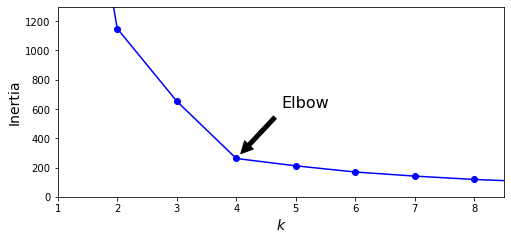

In [76]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X) for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])
plt.show()

As you can see, there is an elbow at $k=4$, which means that less clusters than that would be bad, and more clusters would not help much and might cut clusters in half. So $k=4$ is a pretty good choice. Of course in this example it is not perfect since it means that the two blobs in the lower left will be considered as just a single cluster, but it's a pretty good clustering nonetheless.

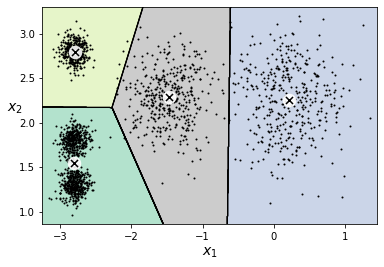

In [77]:
plot_decision_boundaries(kmeans_per_k[4-1], X)
plt.show()

A more precise approach (but also more computationally expensive) is to use the **silhouette score**. An instance’s silhouette coefficient is equal to $(b – a) / max(a, b)$, where a is the mean distance to the other instances in the same cluster (i.e., the mean intra-cluster distance) and b is the mean nearest-cluster distance (i.e., the mean distance to the instances of the next closest cluster, defined as the one that minimizes b, excluding the instance’s own cluster). The silhouette coefficient can vary between –1 and +1. A coefficient close to +1 means that the instance is well inside its own cluster and far from other clusters, while a coefficient close to 0 means that it is close to a cluster boundary, and finally a coefficient close to –1 means that the instance may have been assigned to the wrong cluster.

To compute the silhouette score, we can use Scikit-Learn’s **silhouette_score()** function, giving it all the instances in the dataset and the labels they were assigned.

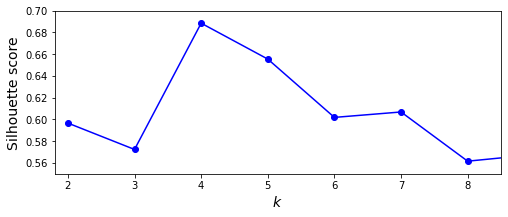

In [78]:
from sklearn.metrics import silhouette_score

silhouette_scores = [silhouette_score(X, model.labels_) for model in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])

plt.show()

As you can see, this visualization is much richer than the previous one: in particular, although it confirms that $k=4$ is a very good choice, but it also underlines the fact that $k=5$ is quite good as well.

An even more informative visualization is obtained when you plot every instance’s silhouette coefficient, sorted by the cluster they are assigned to and by the value of the coefficient. This is called a **silhouette diagram**.

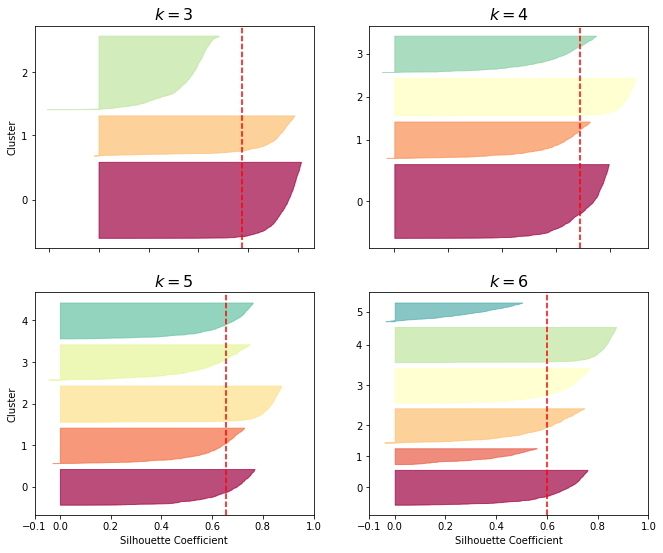

In [79]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

Each diagram contains one knife shape per cluster. The shape’s height indicates the number of instances the cluster contains, and its width represents the sorted silhouette coefficients of the instances in the cluster (wider is better). The vertical dashed lines represent the silhouette score for each number of clusters. 

When most of the instances in a cluster have a lower coefficient than this score (i.e., if many of the instances stop short of the dashed line, ending to the left of it), then the cluster is rather bad since this means its instances are much too close to other clusters. When $k=4$ or $k=5$, the clusters look pretty good: most instances extend beyond the dashed line, to the right and closer to 1.0. When $k=5$, all clusters have similar sizes. So, even though the overall silhouette score from $k=4$ is slightly greater than for $k=5$, it seems like a good idea to use $k=5$ to get clusters of similar sizes.

## Examples of clustering

Let’s look at a few ways we can benefit from clustering.

### Image segmentation

Image segmentation is the task of partitioning an image into multiple segments. In semantic segmentation, all pixels that are part of the same object type get assigned to the same segment. For example, in a self-driving car’s vision system, all pixels that are part of a pedestrian’s image might be assigned to the “pedestrian” segment In instance segmentation, all pixels that are part of the same individual object are assigned to the same segment. In this case there would be a different segment for each pedestrian. The state of the art in semantic or instance segmentation today is achieved using complex architectures based on convolutional neural networks. Here, we are going to do something much simpler: color segmentation. We will simply assign pixels to the same segment if they have a similar color. In some applications, this may be sufficient. For example, if you want to analyze satellite images to measure how much total forest area there is in a region, color segmentation may be just fine.

We can use Matplotlib **imread()** function to load an image. The image is represented as a 3D array. The first dimension’s size is the height; the second is the width; and the third is the number of color channels. In other words, for each
pixel there is a 3D vector containing the intensities of red, green, and blue, each between 0.0 and 1.0. Some images may have fewer channels, such as grayscale images (one channel). And some images may have more channels, such as images with an additional alpha channel for transparency or satellite images, which often contain channels for many light frequencies. we need to reshape the array to get a long list of RGB colors, then we cluster it colors using K-Means. Finally, we reshape this long list of colors to get the same shape as the original image.

In [80]:
from matplotlib.image import imread
image = imread("ladybug.png")
image.shape

(533, 800, 3)

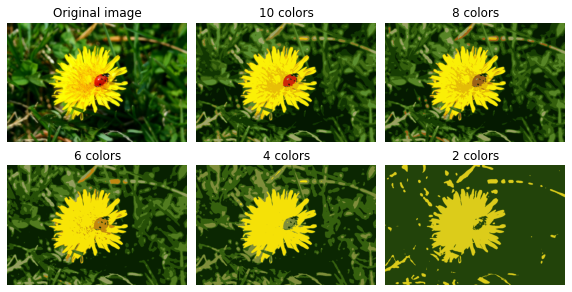

In [81]:
X = image.reshape(-1, 3)

kmeans = KMeans(n_clusters=8, random_state=42).fit(X)

segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))
    
plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx])
    plt.title("{} colors".format(n_clusters))
    plt.axis('off')

plt.show()

We can experiment with various numbers of clusters. When we use fewer than eight clusters, notice that the ladybug’s flashy red color fails to get a cluster of its own: it gets merged with colors from the environment. This is because K-Means prefers clusters of similar sizes. The ladybug is small—much smaller than the rest of the image—so even though its color is flashy, K-Means fails to dedicate a cluster to it.

### Preprocessing

Clustering can be an efficient approach to dimensionality reduction, in particular as a preprocessing step before a supervised learning algorithm. As an example, let’s tackle the digits dataset (a simple MNIST-like dataset containing 1,797 grayscale 8 × 8 images representing the digits 0 to 9).

We load the datase, then split it into a training and testin set, fit a logistic regression model and finally we evaluate the accuracy of the model:

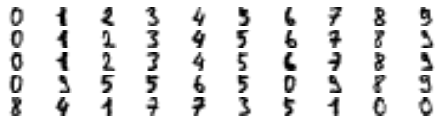

In [113]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits

instances = X_digits[:50]
plt.figure(figsize=(8, 2))
for index, instances in enumerate(instances):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(instances.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')
plt.show()

Ths is our baseline accuracy. Let’s see if we can do better by using K-Means as a preprocessing step. We will create a pipeline that will first cluster the training set into 50 clusters and replace the images with their distances to these 50 clusters, then apply a logistic regression model.

Since there are 10 different digits, it is tempting to set the number of clusters to 10. However, each digit can be written several different ways, so it is preferable to use a larger number of clusters, such as 50.

In [114]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50, random_state=42)),
    ("log_reg", LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)),
])

pipeline.fit(X_train, y_train)

pipeline.score(X_test, y_test)

0.98

We reduced the error rate.  But we chose the number of clusters $k$ arbitrarily; we can surely do better. Since K-Means is just a preprocessing step in a classification pipeline, finding a good value for $k$ is much simpler than earlier. There’s no need to perform silhouette analysis or minimize the inertia; the best value of $k$ is
simply the one that results in the best classification performance during cross-validation. We can use GridSearchCV to find the optimal number of clusters:

In [116]:
from sklearn.model_selection import GridSearchCV

param_grid = dict(kmeans__n_clusters=range(45, 58))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train, y_train)


print(grid_clf.best_params_)
print(grid_clf.score(X_test, y_test))

Fitting 3 folds for each of 13 candidates, totalling 39 fits
[CV] kmeans__n_clusters=45 ...........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................ kmeans__n_clusters=45, total=   3.4s
[CV] kmeans__n_clusters=45 ...........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s


[CV] ............................ kmeans__n_clusters=45, total=   3.5s
[CV] kmeans__n_clusters=45 ...........................................
[CV] ............................ kmeans__n_clusters=45, total=   3.3s
[CV] kmeans__n_clusters=46 ...........................................
[CV] ............................ kmeans__n_clusters=46, total=   3.2s
[CV] kmeans__n_clusters=46 ...........................................
[CV] ............................ kmeans__n_clusters=46, total=   3.6s
[CV] kmeans__n_clusters=46 ...........................................
[CV] ............................ kmeans__n_clusters=46, total=   3.7s
[CV] kmeans__n_clusters=47 ...........................................
[CV] ............................ kmeans__n_clusters=47, total=   3.5s
[CV] kmeans__n_clusters=47 ...........................................
[CV] ............................ kmeans__n_clusters=47, total=   3.3s
[CV] kmeans__n_clusters=47 ...........................................
[CV] .

[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:  2.2min finished


{'kmeans__n_clusters': 57}
0.98


### Semi-supervised Learning

Another use case is in **semi-supervised learning**, when we have plenty of unlabeled instances and very few labeled instances. Let’s train a logistic regression model on a sample of 50 labeled instances from the digits dataset

In [117]:
n_labeled = 50

log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", random_state=42)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])
log_reg.score(X_test, y_test)

0.8333333333333334

Of course, the accuracy is much lower than earlier, when we trained the model on the full training set. 

First, let’s cluster the training set into 50 clusters. Then for each cluster, let’s find the image closest to the centroid. We will call these images the representative images.

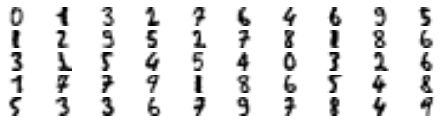

In [126]:
np.random.seed(42)

k = 50
kmeans = KMeans(n_clusters=k, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)

plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')
plt.show()

Then, let’s look at each image and manually label it:

In [127]:
y_representative_digits = np.array([
    0, 1, 3, 2, 7, 6, 4, 6, 9, 5,
    1, 2, 9, 5, 2, 7, 8, 2, 8, 6,
    3, 1, 5, 4, 5, 4, 0, 3, 2, 6,
    1, 7, 7, 9, 1, 8, 6, 5, 4, 8,
    5, 3, 3, 6, 7, 9, 7, 8, 4, 9])

Now we have a dataset with just 50 labeled instances, but instead of being completely random instances, each of them is a representative image of its cluster. Let's see if the performance is any better:

In [128]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.9177777777777778

Wow! We jumped a lot, although we are still only training the model on 50 instances. Since it's often costly and painful to label instances, especially when it has to be done manually by experts, it's a good idea to make them label representative instances rather than just random instances.

But perhaps we can go one step further: what if we propagated the labels to all the other instances in the same cluster? This is called **label propagation**

In [129]:
y_train_propagated = np.empty(len(X_train), dtype=np.int32)
for i in range(k):
    y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]
    
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train_propagated)

log_reg.score(X_test, y_test)

0.9311111111111111

We got a little accuracy boost. But we should probably have propagated the labels only to the instances closest to the centroid, because by propagating to the full cluster, we have certainly included some outliers. 

To continue improving the model and the training set, the next step could be to do a few rounds of **active learning**, which is when a human expert interacts with the learning algorithm, providing labels for specific instances when the algorithm requests them. There are many different strategies for active learning, but one of the most common ones is called **uncertainty sampling**:
1. The model is trained on the labeled instances gathered so far, and this model is used to make predictions on all the unlabeled instances.
2. The instances for which the model is most uncertain (i.e., when its estimated probability is lowest) are given to the expert to be labeled.
3. You iterate this process until the performance improvement stops being worth the labeling effort.

## DBSCAN

DBSCAN is another popular clustering algorithm that illustrates a very different approach based on local density estimation. This approach allows the algorithm to identify clusters of arbitrary shapes. Here is how it works:
- For each instance, the algorithm counts how many instances are located within a small distance $\epsilon$ from it. This region is called the instance’s $\epsilon$-neighborhood.
- If an instance has at least min_samples instances in its $\epsilon$-neighborhood (including itself), then it is considered a core instance. In other words, core instances are those that are located in dense regions.
- All instances in the neighborhood of a core instance belong to the same cluster. This neighborhood may include other core instances; therefore, a long sequence of neighboring core instances forms a single cluster.
- Any instance that is not a core instance and does not have one in its neighborhood is considered an anomaly.

This algorithm works well if all the clusters are dense enough and if they are well separated by low-density regions. 

In Scikit-Learn we have the **DBSCAN class**. Let’s test it on the moons dataset.

In [177]:
from sklearn.datasets import make_moons
from sklearn.cluster import DBSCAN

X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)

dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

DBSCAN(eps=0.05)

The labels of all the instances are now available in the **labels_** instance
variable:

In [178]:
dbscan.labels_[:10]

array([ 0,  2, -1, -1,  1,  0,  0,  0,  2,  5])

Notice that some instances have a cluster index equal to –1, which means that they are considered as anomalies by the algorithm. The indices of the core instances are available in the **core_sample_indices_** instance variable, and the core instances themselves are available in the **components_** instance variable:

In [179]:
dbscan.core_sample_indices_[:10]

array([ 0,  4,  5,  6,  7,  8, 10, 11, 12, 13])

In [180]:
dbscan.components_[:3]

array([[-0.02137124,  0.40618608],
       [-0.84192557,  0.53058695],
       [ 0.58930337, -0.32137599]])

In [181]:
np.unique(dbscan.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6])

In [182]:
def plot_dbscan(dbscan, X):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)
    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    plt.scatter(cores[:, 0], cores[:, 1], c=dbscan.labels_[core_mask], marker='o', s=10, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1], c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

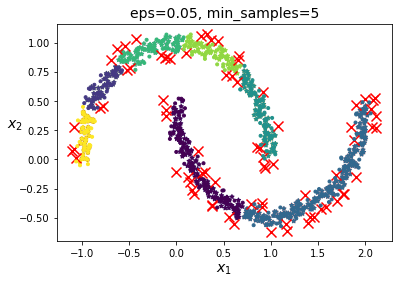

In [183]:
plot_dbscan(dbscan, X)

The algorithm identify quite a lot of anomalies and seven different clusters. We can widen each instance’s neighborhood by increasing **eps** value, in order to get less clusters and anomalies.

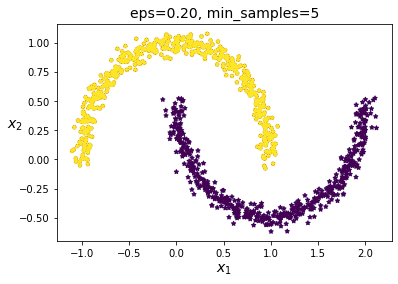

In [184]:
dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

plot_dbscan(dbscan2, X)

Surprisingly, the DBSCAN class does not have a predict() method, although it has a fit_predict() method. In other words, it cannot predict which cluster a new instance belongs to. This implementation decision was made because different classification algorithms can be better for different tasks, so the authors decided to let the user choose which one to use. For example, let’s train a KNeighborsClassifier.

In [185]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan2.components_, dbscan2.labels_[dbscan2.core_sample_indices_])

KNeighborsClassifier(n_neighbors=50)

Now, given a few new instances, we can predict which cluster they most likely belong to and even estimate a probability for each cluster.

In [186]:
X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
knn.predict(X_new)

array([1, 0, 1, 0])

In [187]:
knn.predict_proba(X_new)

array([[0.18, 0.82],
       [1.  , 0.  ],
       [0.12, 0.88],
       [1.  , 0.  ]])

We can plot the decision boundary (the crosses represent the four instances in X_new).

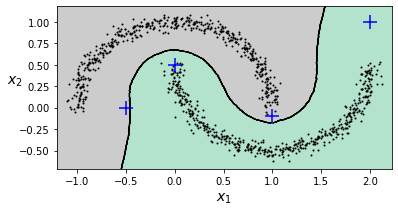

In [188]:
plt.figure(figsize=(6, 3))
plot_decision_boundaries(knn, X, show_centroids=False)
plt.scatter(X_new[:, 0], X_new[:, 1], c="b", marker="+", s=200, zorder=10)
plt.show()

Notice that since there is no anomaly in the training set, the classifier always chooses a cluster, even when that cluster is far away. It is fairly straightforward to introduce a maximum distance, in which case the two instances that are far away from both clusters are classified as anomalies. To do this, we can use the **kneighbors()** method of the KNeighborsClassifier. Given a set of instances, it returns the distances and the indices of the k nearest neighbors in the training set (two matrices, each with k columns).

In [191]:
y_dist, y_pred_idx = knn.kneighbors(X_new, n_neighbors=1)
y_pred = dbscan2.labels_[dbscan2.core_sample_indices_][y_pred_idx]
y_pred[y_dist > 0.2] = -1
y_pred.ravel()

array([-1,  0,  1, -1])

In short, DBSCAN is a very simple yet powerful algorithm capable of identifying any number of clusters of any shape. It is robust to outliers, and it has just two hyperparameters (eps and min_samples). If the density varies significantly across the clusters, however, it can be impossible for it to capture all the clusters properly.

## Gaussian Mixtures

A **Gaussian mixture model (GMM)** is a probabilistic model that assumes that the instances were generated from a mixture of several Gaussian distributions whose parameters are unknown. All the instances generated from a single Gaussian distribution form a cluster that typically looks like an ellipsoid. Each cluster can have a different ellipsoidal shape, size, density, and orientation. When you observe an instance, you know it was generated from one of the Gaussian distributions, but you are not told which one, and you do not know what the parameters of these distributions are.

There are several GMM variants. In the simplest variant, implemented in the **GaussianMixture class**, you must know in advance the number $k$ of Gaussian distributions. The dataset X is assumed to have been generated through the following probabilistic process:
- For each instance, a cluster is picked randomly from among $k$ clusters. The probability of choosing the $j$ cluster is defined by the cluster’s weight $\phi^{(j)}$ . The index of the cluster chosen for the $i$ instance is noted $z^{(i)}$
- If $z^{(i)}=j$ (meaning the $i$ instance has been assigned to the $j$ cluster) the location $x$ of this instance is sampled randomly from the Gaussian distribution with mean $\mu^{(j)}$ and covariance matrix $\Sigma^{(j)}$.

This generative process can be represented as a graphical model:

<img src="./images/gaussian-mixture.png" width="600">

The notations are standard **plate notation**:
- The circles represent random variables. 
- The squares represent fixed values (i.e., parameters of the model). 
- The large rectangles are called plates. They indicate that their content is repeated several times. The number at the bottom right of each plate indicates how many times its content is repeated. 
- The solid arrows represent conditional dependencies. An arrow that crosses a plate boundary means that it applies to all the repetitions of that plate.
- The squiggly arrow represents a switch:  the value of the variable selects, for the other incoming variables, which value to use out of the $k$ array of possible values.
- Shaded nodes indicate that the value is known. They are called **observed variables**. The unknown random variables are called **latent variables**.

In that case, there are $m$ random variables $z^{(i)}$ (from $z^{(1)}$ to $z^{(m)}$ ) and $m$ random variables $x^{(i)}$ . There are also $k$ means $\mu^{(j)}$ and $k$ covariance matrices $\Sigma^{(j)}$ . Lastly, there is just one weight vector $\phi$ containing all the weights $\phi^{(1)}$ to $\phi^{(k)}$. Each variable $z^{(i)}$ is drawn from the categorical distribution with weights $\phi$. Each variable $x^{(i)}$ is drawn from the normal distribution, with the mean and covariance matrix defined by its cluster $z^{(i)}$. Only the random variables $x^{(i)}$ are observed variables.

What can we do with such a model? Well, given the dataset $X$, we typically want to start by estimating the weights $\phi$ and all the distribution parameters $\mu^{(j)}$ and $\Sigma^{(j)}$ . 

Scikit-Learn’s **GaussianMixture class** makes this.

In [192]:
from sklearn.mixture import GaussianMixture

X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X)

GaussianMixture(n_components=3, n_init=10, random_state=42)

Let's look at the parameters that the EM algorithm estimated:

In [193]:
gm.weights_

array([0.39054348, 0.2093669 , 0.40008962])

In [194]:
gm.means_

array([[ 0.05224874,  0.07631976],
       [ 3.40196611,  1.05838748],
       [-1.40754214,  1.42716873]])

In [195]:
gm.covariances_

array([[[ 0.6890309 ,  0.79717058],
        [ 0.79717058,  1.21367348]],

       [[ 1.14296668, -0.03114176],
        [-0.03114176,  0.9545003 ]],

       [[ 0.63496849,  0.7298512 ],
        [ 0.7298512 ,  1.16112807]]])

Did the algorithm actually converge?

In [143]:
gm.converged_

True

Yes, good. How many iterations did it take?

In [144]:
gm.n_iter_

4

It worked fine! Indeed, the weights that were used to generate the data were 0.2, 0.4, and 0.4; and similarly, the means and covariance matrices were very close to those found by the algorithm.

The implemented method is the **Expectation-Maximization (EM)** algorithm, which has
many similarities with the K-Means algorithm: it also initializes the cluster parameters randomly, then it repeats two steps until convergence, first assigns instances to clusters ("expectation" step), then updats the clusters ("maximization" step). We can think of EM as a generalization of K-Means that not only finds the cluster centers ($\mu^{(j)}$), but also their size, shape, and orientation ($\Sigma^{(j)}$), as well as their relative weights ($\phi$). Unlike K-Means, EM uses soft cluster assignments, not hard assignments. For each instance, during the
expectation step, the algorithm estimates the probability that it belongs to each cluster. Then, during the maximization step, each cluster is updated using all the instances in the dataset, with each instance weighted by the estimated probability that it belongs to that cluster. These probabilities are called the responsibilities of the clusters for the instances.

Now we have an estimate of the location, size, shape, orientation, and relative weight of each cluster, and we can use the model to assign each instance to
the most likely cluster or estimate the probability that it belongs to a particular cluster (soft clustering). Just using the predict() or the predict_proba() methods

In [146]:
gm.predict_proba(X)

array([[2.32389467e-02, 6.77397850e-07, 9.76760376e-01],
       [1.64685609e-02, 6.75361303e-04, 9.82856078e-01],
       [2.01535333e-06, 9.99923053e-01, 7.49319577e-05],
       ...,
       [9.99999571e-01, 2.13946075e-26, 4.28788333e-07],
       [1.00000000e+00, 1.46454409e-41, 5.12459171e-16],
       [1.00000000e+00, 8.02006365e-41, 2.27626238e-15]])

A Gaussian mixture model is a **generative model**, meaning we can sample new instances from it

In [196]:
X_new, y_new = gm.sample(6)
X_new

array([[-0.8690223 , -0.32680051],
       [ 0.29945755,  0.2841852 ],
       [ 1.85027284,  2.06556913],
       [ 3.98260019,  1.50041446],
       [ 3.82006355,  0.53143606],
       [-1.04015332,  0.7864941 ]])

In [197]:
y_new

array([0, 0, 1, 1, 1, 2])

Notice that they are sampled sequentially from each cluster.

It is also possible to estimate the density of the model at any given location. This is achieved using the **score_samples()** method: for each instance it is given, this method estimates the log of the probability density function at that location. The greater the score, the higher the density.

In [198]:
gm.score_samples(X)

array([-2.60674489, -3.57074133, -3.33007348, ..., -3.51379355,
       -4.39643283, -3.8055665 ])

If we compute the exponential of these scores, we get the value of the probability density function at the location of the given instances. To estimate the probability that an instance will fall within a particular region, we have to integrate the probability density function over that region.

We can check that the probability integrates to 1 over the whole space. We just take a large square around the clusters, and chop it into a grid of tiny squares, then we compute the approximate probability that the instances will be generated in each tiny square (by multiplying the probability density function at one corner of the tiny square by the area of the square), and finally summing all these probabilities. The result should be very close to 1.

In [199]:
resolution = 100
grid = np.arange(-10, 10, 1 / resolution)
xx, yy = np.meshgrid(grid, grid)
X_full = np.vstack([xx.ravel(), yy.ravel()]).T

pdf = np.exp(gm.score_samples(X_full))
pdf_probas = pdf * (1 / resolution) ** 2
pdf_probas.sum()

0.9999999999271592

Now we can shows the cluster means, the decision boundaries (dashed lines), and the density contours of the model.

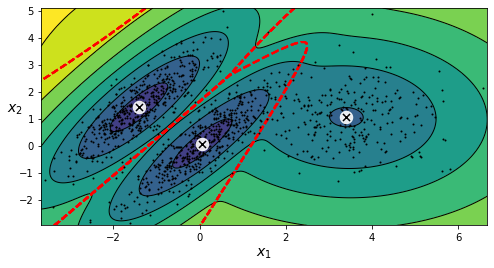

In [200]:
from matplotlib.colors import LogNorm

def plot_gaussian_mixture(clusterer, X, resolution=1000):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution), np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, norm=LogNorm(vmin=1.0, vmax=30.0), levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z, norm=LogNorm(vmin=1.0, vmax=30.0), levels=np.logspace(0, 2, 12), linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)
    
plt.figure(figsize=(8, 4))
plot_gaussian_mixture(gm, X)
plt.show()

The algorithm clearly found an excellent solution. Of course, we made its task easy by generating the data using a set of 2D Gaussian distributions. Unfortunately, real-life data is not always so Gaussian and low-dimensional). We also gave the algorithm the correct number of clusters. When there are many dimensions, or many clusters, or few instances, EM can struggle to converge to the optimal solution. 

We might need to reduce the difficulty of the task by limiting the number of parameters that the algorithm has to learn. One way to do this is to limit the range of shapes and orientations that the clusters can have. This can be achieved by imposing constraints on the covariance matrices. To do this, set the **covariance_type** hyperparameter to one of the following values:
- "full" (default): no constraint, all clusters can take on any ellipsoidal shape of any size.
- "tied": all clusters must have the same shape, which can be any ellipsoid (i.e., they all share the same covariance matrix).
- "spherical": all clusters must be spherical, but they can have different diameters (i.e., different variances).
- "diag": clusters can take on any ellipsoidal shape of any size, but the ellipsoid's axes must be parallel to the axes (i.e., the covariance matrices must be diagonal).

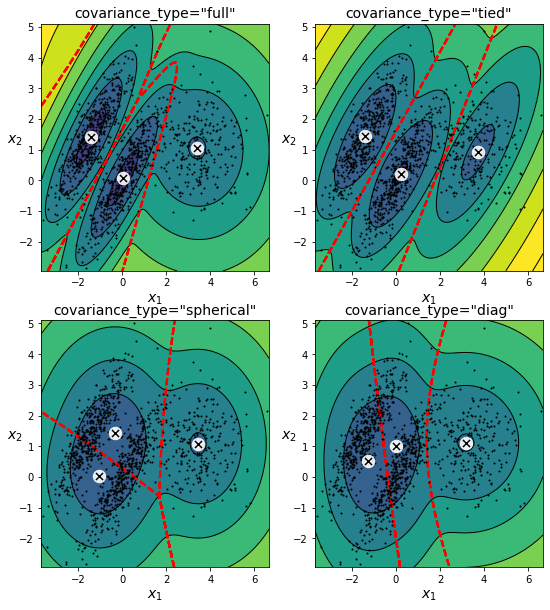

In [204]:
gm_full = GaussianMixture(n_components=3, n_init=10, covariance_type="full", random_state=42)
gm_tied = GaussianMixture(n_components=3, n_init=10, covariance_type="tied", random_state=42)
gm_spherical = GaussianMixture(n_components=3, n_init=10, covariance_type="spherical", random_state=42)
gm_diag = GaussianMixture(n_components=3, n_init=10, covariance_type="diag", random_state=42)

gm_full.fit(X)
gm_tied.fit(X)
gm_spherical.fit(X)
gm_diag.fit(X)

plt.figure(figsize=(9, 10))

plt.subplot(221)
plot_gaussian_mixture(gm_full, X)
plt.title('covariance_type="{}"'.format(gm_full.covariance_type), fontsize=14)

plt.subplot(222)
plot_gaussian_mixture(gm_tied, X)
plt.title('covariance_type="{}"'.format(gm_tied.covariance_type), fontsize=14)

plt.subplot(223)
plot_gaussian_mixture(gm_spherical, X)
plt.title('covariance_type="{}"'.format(gm_spherical.covariance_type), fontsize=14)

plt.subplot(224)
plot_gaussian_mixture(gm_diag, X)
plt.title('covariance_type="{}"'.format(gm_diag.covariance_type), fontsize=14)

plt.show()

### Anomaly Detection

**Anomaly detection** (also called **outlier detection**) is the task of detecting
instances that deviate strongly from the norm. These instances are called anomalies, or outliers, while the normal instances are called inliers. Anomaly detection is useful in a wide variety of applications, such as fraud detection, detecting defective products in manufacturing, or removing outliers from a dataset before training another model (which can significantly improve the performance of the resulting model).

Using a Gaussian mixture model for anomaly detection is quite simple: any instance located in a low-density region can be considered an anomaly. We must define what density threshold we want to use. If we notice that we get too many **false positives** (i.e., perfectly items that are flagged as anomalies) we can lower the threshold. Conversely, if we have too many **false negatives** (i.e., anomalies that the system does not flag in that wsay) we can increase the threshold. This is the usual **precision/recall trade-off**. 

Here is how you would identify the outliers using the fourth percentile lowest density as the threshold (i.e., approximately 4% of the instances will be flagged as anomalies).

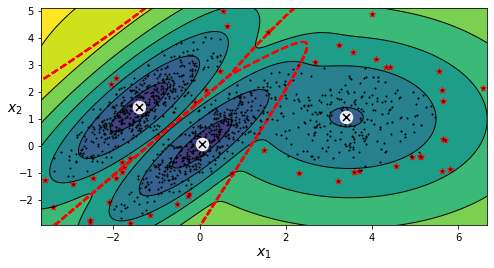

In [205]:
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 4)
anomalies = X[densities < density_threshold]

plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=5.1)

plt.show()

### Selecting the Number of Clusters

With K-Means, we can use the inertia or the silhouette score to select the appropriate number of clusters. But with Gaussian mixtures, it is not possible because this metrics are not reliable when the clusters are not spherical or have different sizes. Instead, we can try to find the model that minimizes a theoretical information criterion, such as the **Bayesian information criterion (BIC)** or the **Akaike information criterion (AIC)**, defined as

${BIC} = {\log(m)p - 2\log({\hat L})}$

${AIC} = 2p - 2\log(\hat L)$

Where
- $m$ is the number of instances.
- $p$ is the number of parameters learned by the model.
- $\hat L$ is the maximized value of the likelihood function of the model.

The terms “probability” and “likelihood” are often used interchangeably in the common language, but they have very different meanings in statistics. Given a statistical model with some parameters $\theta$, the word **probability** is used to describe how plausible a future outcome $x$ is (knowing the parameter values $\theta$), while the word “likelihood” is used to describe how plausible a particular set of parameter values $\theta$ is, after the outcome $x$ is known.

Both BIC and AIC penalize models that have more parameters to learn (e.g., more clusters), and reward models that fit the data well (i.e., models that give a high likelihood to the observed data). They often end up selecting the same model. When they differ, the model selected by the BIC tends to be simpler (fewer parameters) than the one selected by the AIC, but tends to not fit the data quite as well (this is especially true for larger datasets).

To compute the BIC and AIC, call the **bic()** and **aic()** methods.

In [206]:
gm.bic(X)

8189.662685850679

In [207]:
gm.aic(X)

8102.437405735641

We can calculate BIC and AIC for different numbers of clusters $k$.

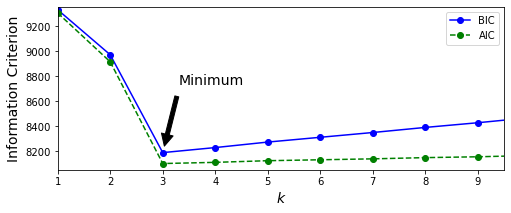

In [208]:
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X) for k in range(1, 11)]

bics = [model.bic(X) for model in gms_per_k]
aics = [model.aic(X) for model in gms_per_k]

plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bics, "bo-", label="BIC")
plt.plot(range(1, 11), aics, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 9.5, np.min(aics) - 50, np.max(aics) + 50])
plt.annotate('Minimum',
             xy=(3, bics[2]),
             xytext=(0.35, 0.6),
             textcoords='figure fraction',
             fontsize=14,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.legend()
plt.show()

As you can see, both the BIC and the AIC are lowest when k=3, so it is most likely the best choice. 

Note that we could also search for the best value for the covariance_type hyperparameter. For example, if it is "spherical" rather than "full", then the model has significantly fewer parameters to learn, but it does not fit the data as well.

In [209]:
min_bic = np.infty

for k in range(1, 11):
    for covariance_type in ("full", "tied", "spherical", "diag"):
        bic = GaussianMixture(n_components=k, n_init=10,
                              covariance_type=covariance_type,
                              random_state=42).fit(X).bic(X)
        if bic < min_bic:
            min_bic = bic
            best_k = k
            best_covariance_type = covariance_type

In [210]:
best_k

3

In [211]:
best_covariance_type

'full'

Gaussian mixture models work great on clusters with ellipsoidal shapes, but if you try to fit a dataset with different shapes, you may have bad surprises. For example, let’s see what happens if we use a Bayesian Gaussian mixture model to cluster the moons dataset.

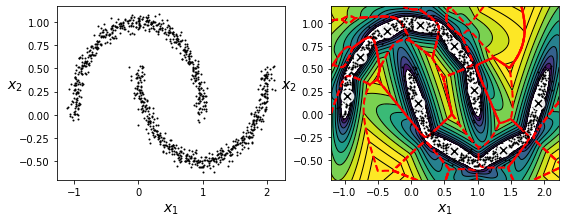

In [221]:
X_moons, y_moons = make_moons(n_samples=1000, noise=0.05, random_state=42)

bgm = GaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X_moons)

plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_data(X_moons)
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14, rotation=0)

plt.subplot(122)
plot_gaussian_mixture(bgm, X_moons)

plt.show()

Oops! The algorithm desperately searched for ellipsoids, so it found eight different clusters instead of two. The density estimation is not too bad, so this model could perhaps be used for anomaly detection, but it failed to identify the two moons.

## Exercise

**1 - The classic Olivetti faces dataset contains 400 grayscale 64×64–pixel images of faces. Each image is flattened to a 1D vector of size 4,096. 40 different people were photographed (10 times each), and the usual task is to train a model that can predict which person is represented in each picture. Load the dataset using the sklearn.datasets.fetch_olivetti_faces() function.**

In [222]:
from sklearn.datasets import fetch_olivetti_faces

olivetti = fetch_olivetti_faces()

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /Users/riccardo.berta/scikit_learn_data


**2 - Split it into a training set, a validation set, and a test set (note that the dataset is already scaled between 0 and 1). Since the dataset is quite small, you probably want to use stratified sampling to ensure that there are the same number of images per person in each set.**

In [223]:
from sklearn.model_selection import StratifiedShuffleSplit

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=40, random_state=42)
train_valid_idx, test_idx = next(strat_split.split(olivetti.data, olivetti.target))
X_train_valid = olivetti.data[train_valid_idx]
y_train_valid = olivetti.target[train_valid_idx]
X_test = olivetti.data[test_idx]
y_test = olivetti.target[test_idx]

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=80, random_state=43)
train_idx, valid_idx = next(strat_split.split(X_train_valid, y_train_valid))
X_train = X_train_valid[train_idx]
y_train = y_train_valid[train_idx]
X_valid = X_train_valid[valid_idx]
y_valid = y_train_valid[valid_idx]

In [224]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(280, 4096) (280,)
(80, 4096) (80,)
(40, 4096) (40,)


**3 - To speed things up, reduce the data's dimensionality using PCA**

In [225]:
from sklearn.decomposition import PCA

pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)

pca.n_components_

199

**4 - Cluster the images using K-Means, and ensure that you have a good number of clusters.**

In [226]:
from sklearn.cluster import KMeans

k_range = range(5, 150, 5)
kmeans_per_k = []
for k in k_range:
    print("k={}".format(k))
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_train_pca)
    kmeans_per_k.append(kmeans)

k=5
k=10
k=15
k=20
k=25
k=30
k=35
k=40
k=45
k=50
k=55
k=60
k=65
k=70
k=75
k=80
k=85
k=90
k=95
k=100
k=105
k=110
k=115
k=120
k=125
k=130
k=135
k=140
k=145


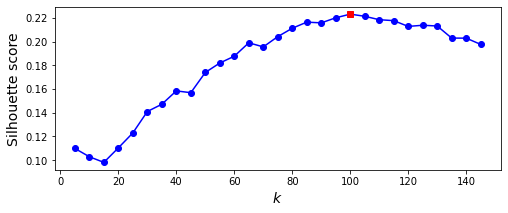

In [227]:
from sklearn.metrics import silhouette_score

silhouette_scores = [silhouette_score(X_train_pca, model.labels_)for model in kmeans_per_k]
best_index = np.argmax(silhouette_scores)
best_k = k_range[best_index]
best_score = silhouette_scores[best_index]

plt.figure(figsize=(8, 3))
plt.plot(k_range, silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.plot(best_k, best_score, "rs")
plt.show()

In [228]:
best_k

100

It looks like the best number of clusters is quite high. You might have expected it to be 40, since there are 40 different people on the pictures. However, the same person may look quite different on different pictures (e.g., with or without glasses, or simply shifted left or right).

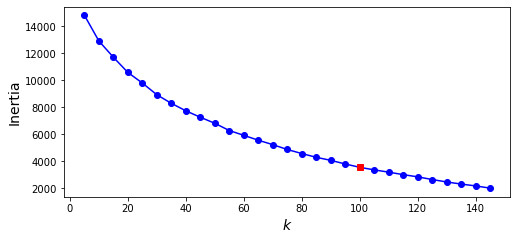

In [229]:
inertias = [model.inertia_ for model in kmeans_per_k]
best_inertia = inertias[best_index]

plt.figure(figsize=(8, 3.5))
plt.plot(k_range, inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.plot(best_k, best_inertia, "rs")
plt.show()

The optimal number of clusters is not clear on this inertia diagram, as there is no obvious elbow, so let's stick with k found from silhouette_score.

In [230]:
best_model = kmeans_per_k[best_index]

**5 - Visualize the clusters: do you see similar faces in each cluster?**

Cluster 0


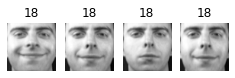

Cluster 1


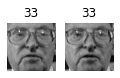

Cluster 2


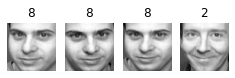

Cluster 3


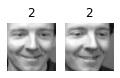

Cluster 4


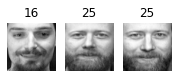

Cluster 5


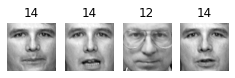

Cluster 6


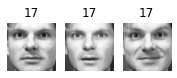

Cluster 7


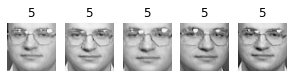

Cluster 8


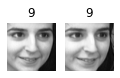

Cluster 9


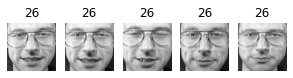

Cluster 10


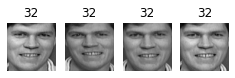

Cluster 11


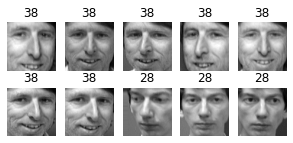

Cluster 12


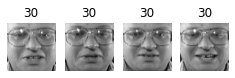

Cluster 13


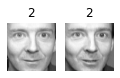

Cluster 14


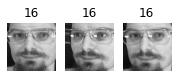

Cluster 15


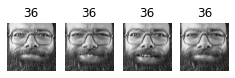

Cluster 16


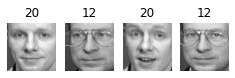

Cluster 17


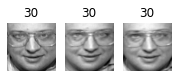

Cluster 18


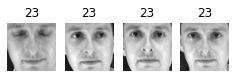

Cluster 19


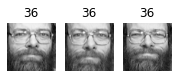

Cluster 20


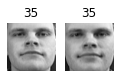

Cluster 21


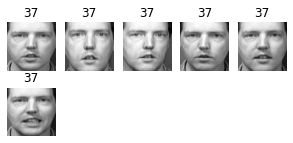

Cluster 22


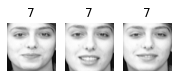

Cluster 23


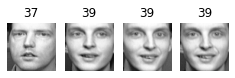

Cluster 24


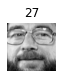

Cluster 25


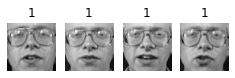

Cluster 26


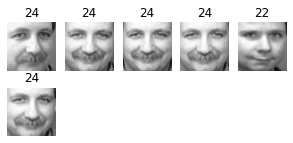

Cluster 27


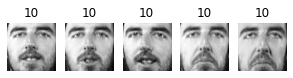

Cluster 28


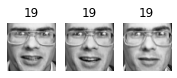

Cluster 29


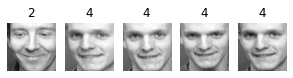

Cluster 30


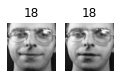

Cluster 31


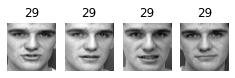

Cluster 32


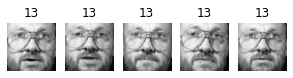

Cluster 33


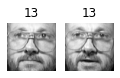

Cluster 34


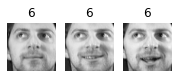

Cluster 35


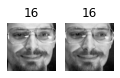

Cluster 36


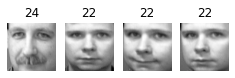

Cluster 37


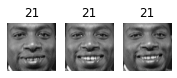

Cluster 38


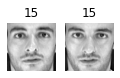

Cluster 39


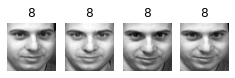

Cluster 40


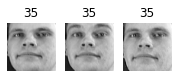

Cluster 41


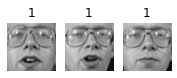

Cluster 42


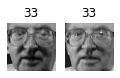

Cluster 43


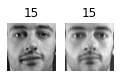

Cluster 44


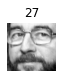

Cluster 45


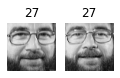

Cluster 46


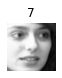

Cluster 47


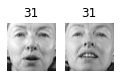

Cluster 48


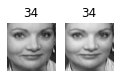

Cluster 49


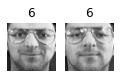

Cluster 50


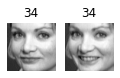

Cluster 51


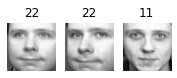

Cluster 52


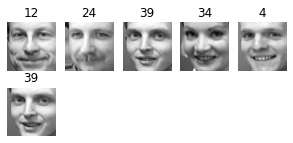

Cluster 53


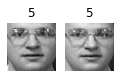

Cluster 54


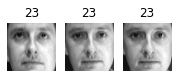

Cluster 55


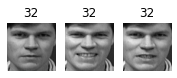

Cluster 56


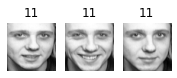

Cluster 57


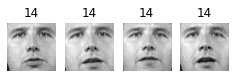

Cluster 58


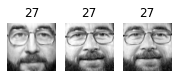

Cluster 59


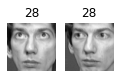

Cluster 60


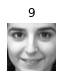

Cluster 61


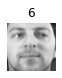

Cluster 62


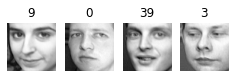

Cluster 63


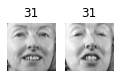

Cluster 64


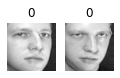

Cluster 65


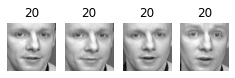

Cluster 66


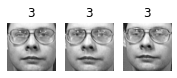

Cluster 67


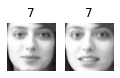

Cluster 68


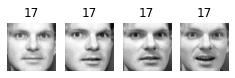

Cluster 69


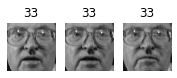

Cluster 70


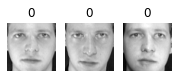

Cluster 71


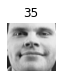

Cluster 72


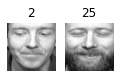

Cluster 73


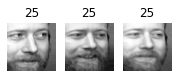

Cluster 74


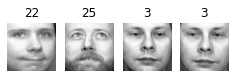

Cluster 75


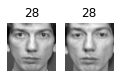

Cluster 76


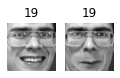

Cluster 77


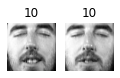

Cluster 78


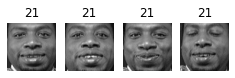

Cluster 79


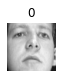

Cluster 80


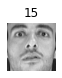

Cluster 81


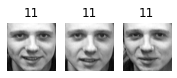

Cluster 82


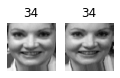

Cluster 83


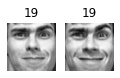

Cluster 84


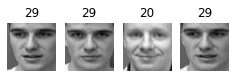

Cluster 85


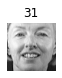

Cluster 86


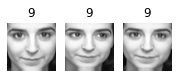

Cluster 87


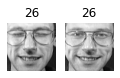

Cluster 88


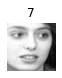

Cluster 89


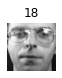

Cluster 90


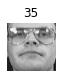

Cluster 91


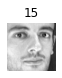

Cluster 92


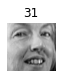

Cluster 93


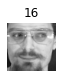

Cluster 94


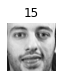

Cluster 95


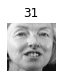

Cluster 96


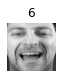

Cluster 97


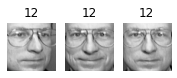

Cluster 98


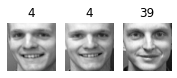

Cluster 99


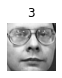

In [231]:
def plot_faces(faces, labels, n_cols=5):
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows * 1.1))
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face.reshape(64, 64), cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()

for cluster_id in np.unique(best_model.labels_):
    print("Cluster", cluster_id)
    in_cluster = best_model.labels_==cluster_id
    faces = X_train[in_cluster].reshape(-1, 64, 64)
    labels = y_train[in_cluster]
    plot_faces(faces, labels)

About 2 out of 3 clusters are useful: that is, they contain at least 2 pictures, all of the same person. However, the rest of the clusters have either one or more intruders, or they have just a single picture.

Clustering images this way may be too imprecise to be directly useful when training a model, but it can be tremendously useful when labeling images in a new dataset: it will usually make labelling much faster.

**6 - Continuing with the Olivetti faces dataset, train a classifier to predict which person is represented in each picture, and evaluate it on the validation set.**

In [232]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf.fit(X_train_pca, y_train)
clf.score(X_valid_pca, y_valid)

0.9

**7 - Use K-Means as a dimensionality reduction tool, and train a classifier on the reduced set.**

In [234]:
X_train_reduced = best_model.transform(X_train_pca)
X_valid_reduced = best_model.transform(X_valid_pca)
X_test_reduced = best_model.transform(X_test_pca)

clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf.fit(X_train_reduced, y_train)
    
clf.score(X_valid_reduced, y_valid)

0.75

That's not better at all! Let's see if tuning the number of clusters helps.

**8 - Search for the number of clusters that allows the classifier to get the best performance: what performance can you reach?**

In [235]:
from sklearn.pipeline import Pipeline

for n_clusters in k_range:
    pipeline = Pipeline([
        ("kmeans", KMeans(n_clusters=n_clusters, random_state=n_clusters)),
        ("forest_clf", RandomForestClassifier(n_estimators=150, random_state=42))
    ])
    pipeline.fit(X_train_pca, y_train)
    print(n_clusters, pipeline.score(X_valid_pca, y_valid))

5 0.3375
10 0.5375
15 0.5875
20 0.6625
25 0.65
30 0.7375
35 0.725
40 0.75
45 0.6875
50 0.7
55 0.725
60 0.775
65 0.7625
70 0.7
75 0.7625
80 0.725
85 0.7125
90 0.7125
95 0.75
100 0.75
105 0.7375
110 0.75
115 0.7375
120 0.7125
125 0.7625
130 0.7375
135 0.775
140 0.8
145 0.75


Oh well, even by tuning the number of clusters, we never get beyond 80% accuracy. Looks like the distances to the cluster centroids are not as informative as the original images.

**9 - What if you append the features from the reduced set to the original features (again, searching for the best number of clusters)?**

In [236]:
X_train_extended = np.c_[X_train_pca, X_train_reduced]
X_valid_extended = np.c_[X_valid_pca, X_valid_reduced]
X_test_extended = np.c_[X_test_pca, X_test_reduced]

In [237]:
clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf.fit(X_train_extended, y_train)
clf.score(X_valid_extended, y_valid)

0.825

That's a bit better, but still worse than without the cluster features. The clusters are not useful to directly train a classifier in this case (but they can still help when labelling new training instances).

**10 - Train a Gaussian mixture model on the Olivetti faces dataset.**

In [238]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=40, random_state=42)
y_pred = gm.fit_predict(X_train_pca)

**11 - Use the model to generate some new faces (using the `sample()` method), and visualize them**

In [239]:
n_gen_faces = 20
gen_faces_reduced, y_gen_faces = gm.sample(n_samples=n_gen_faces)
gen_faces = pca.inverse_transform(gen_faces_reduced)

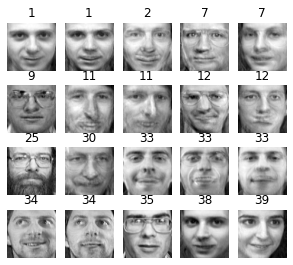

In [240]:
plot_faces(gen_faces, y_gen_faces)

**12 - Try to modify some images (e.g., rotate, flip, darken) and see if the model can detect the anomalies**

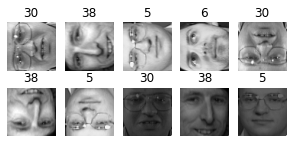

In [241]:
n_rotated = 4
rotated = np.transpose(X_train[:n_rotated].reshape(-1, 64, 64), axes=[0, 2, 1])
rotated = rotated.reshape(-1, 64*64)
y_rotated = y_train[:n_rotated]

n_flipped = 3
flipped = X_train[:n_flipped].reshape(-1, 64, 64)[:, ::-1]
flipped = flipped.reshape(-1, 64*64)
y_flipped = y_train[:n_flipped]

n_darkened = 3
darkened = X_train[:n_darkened].copy()
darkened[:, 1:-1] *= 0.3
darkened = darkened.reshape(-1, 64*64)
y_darkened = y_train[:n_darkened]

X_bad_faces = np.r_[rotated, flipped, darkened]
y_bad = np.concatenate([y_rotated, y_flipped, y_darkened])

plot_faces(X_bad_faces, y_bad)

In [242]:
X_bad_faces_pca = pca.transform(X_bad_faces)

In [243]:
gm.score_samples(X_bad_faces_pca)

array([-1.79997590e+07, -2.26427356e+07, -3.96415759e+07, -4.60254433e+07,
       -3.13975426e+07, -1.39330113e+07, -2.90882891e+07, -1.06298632e+08,
       -1.20931027e+08, -7.49740245e+07])

The bad faces are all considered highly unlikely by the Gaussian Mixture model. Compare this to the scores of some training instances:

In [244]:
gm.score_samples(X_train_pca[:10])

array([1163.02020829, 1149.16682301, 1148.4771048 , 1170.67602911,
       1088.46009667, 1075.71700506, 1075.71700941, 1088.46009043,
       1096.42609831, 1119.68626972])